# 🔮 H-LLM: Hyperbolic Language Model

**Treinamento com GPT-2 Distillation + Chat Interativo**

Features:
- ✅ GPT-2 Tokenizer (50257 tokens reais)
- ✅ WikiText-2 dataset
- ✅ 🎓 **GPT-2 Distillation** (Teacher → Student)
- ✅ Early stopping automático
- ✅ Checkpoints para resume
- ✅ Chat interativo com texto real

---
**Author:** Éric Gustavo Reis de Sena  
**Date:** January 2026

In [ ]:
# Deletar checkpoints antigos
#!rm -rf /content/outputs/h_llm/checkpoints/*
print("✅ Checkpoints deletados")

✅ Checkpoints deletados


In [ ]:
# @title 1.1 Upload CGT Project
from google.colab import files
import zipfile
import os

!rm -rf /content/cgt_project
print('Upload cgt_project_h_llm.zip:')

uploaded = files.upload()
for f in uploaded:
    if f.endswith('.zip'):
        with zipfile.ZipFile(f, 'r') as z:
            z.extractall('/content')
        print(f'✅ Extracted: {f}')
        os.remove(f)

required = ['/content/cgt_project/src/cgt/models/hyperbolic_transformer_hardened.py']
for p in required:
    print(f'✅ {p}' if os.path.exists(p) else f'❌ MISSING: {p}')

Upload cgt_project_h_llm.zip:


Saving cgt_project_h_llm.zip to cgt_project_h_llm.zip
✅ Extracted: cgt_project_h_llm.zip
✅ /content/cgt_project/src/cgt/models/hyperbolic_transformer_hardened.py


In [ ]:
# @title 1.2 Install Dependencies
!pip install -q transformers datasets tqdm POT torch
# @title 0. Fix PyTorch (executar primeiro)
import importlib
import sys

# Limpar módulos torch parcialmente carregados
mods_to_remove = [k for k in sys.modules if 'torch' in k]
for m in mods_to_remove:
    del sys.modules[m]

print("✅ Módulos limpos. Continue com as próximas células.")

✅ Módulos limpos. Continue com as próximas células.


In [ ]:
# @title 2. Setup & Imports
import sys
sys.path.insert(0, '/content/cgt_project/src')

import os, json, math, time
from datetime import datetime
from pathlib import Path
from dataclasses import dataclass, asdict
from typing import Optional, Dict, List, Any

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np

# GPT-2 Tokenizer
from transformers import GPT2Tokenizer
from datasets import load_dataset

# CGT H-LLM
from cgt.models.hyperbolic_transformer_hardened import (
    HyperbolicTransformerHardened,
    HyperbolicTransformerConfig,
)

print(f"PyTorch: {torch.__version__}")
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {DEVICE}")

OUTPUT_DIR = Path('/content/outputs/h_llm')
CHECKPOINT_DIR = OUTPUT_DIR / 'checkpoints'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)

PyTorch: 2.9.0+cu126
Device: cuda


In [ ]:
# @title 3. Load GPT-2 Tokenizer
print("🔄 Loading GPT-2 tokenizer...")
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

print(f"✅ Tokenizer loaded")
print(f"   Vocab size: {tokenizer.vocab_size}")
print(f"   EOS token: {tokenizer.eos_token} (id={tokenizer.eos_token_id})")
print(f"   PAD token: {tokenizer.pad_token} (id={tokenizer.pad_token_id})")

# Test
test_text = "Hello, I am a hyperbolic language model!"
tokens = tokenizer.encode(test_text)
decoded = tokenizer.decode(tokens)
print(f"\n   Test: '{test_text}'")
print(f"   Tokens: {tokens}")
print(f"   Decoded: '{decoded}'")

🔄 Loading GPT-2 tokenizer...


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

✅ Tokenizer loaded
   Vocab size: 50257
   EOS token: <|endoftext|> (id=50256)
   PAD token: <|endoftext|> (id=50256)

   Test: 'Hello, I am a hyperbolic language model!'
   Tokens: [15496, 11, 314, 716, 257, 8718, 65, 4160, 3303, 2746, 0]
   Decoded: 'Hello, I am a hyperbolic language model!'


In [ ]:
# @title 4. Configuration
@dataclass
class TrainingConfig:
    # Model - GPT-2 vocab
    vocab_size: int = 50257  # GPT-2 vocab size
    n_embd: int = 128        # Embedding dimension
    n_layer: int = 4         # Transformer layers
    n_head: int = 8          # Attention heads
    n_positions: int = 256   # Max sequence length
    dropout: float = 0.1
    embedding_init_std: float = 0.001  # ← MUDANÇA: era 0.02

    # Training
    batch_size: int = 8
    learning_rate: float = 1e-4
    weight_decay: float = 0.01
    max_steps: int = 50000
    warmup_steps: int = 1000
    gradient_clip: float = 0.5

    # Data
    seq_length: int = 128

    # Early Stopping
    early_stopping_patience: int = 10
    early_stopping_min_delta: float = 0.01

    # Checkpointing
    checkpoint_every: int = 1000
    eval_every: int = 500
    log_every: int = 100
    keep_last_n_checkpoints: int = 3

    def to_model_config(self):
        return HyperbolicTransformerConfig(
            vocab_size=self.vocab_size,
            n_embd=self.n_embd,
            n_layer=self.n_layer,
            n_head=self.n_head,
            n_positions=self.n_positions,
            dropout=self.dropout,
            attention_dropout=self.dropout,
            embedding_init_std=self.embedding_init_std,
            radius_max=3.0,  # ← MUDANÇA: adicionar limite de raio
        )

config = TrainingConfig()
print("="*50)
print("CONFIGURATION")
print("="*50)
for k, v in asdict(config).items():
    print(f"  {k}: {v}")

CONFIGURATION
  vocab_size: 50257
  n_embd: 128
  n_layer: 4
  n_head: 8
  n_positions: 256
  dropout: 0.1
  embedding_init_std: 0.001
  batch_size: 8
  learning_rate: 0.0001
  weight_decay: 0.01
  max_steps: 50000
  warmup_steps: 1000
  gradient_clip: 0.5
  seq_length: 128
  early_stopping_patience: 10
  early_stopping_min_delta: 0.01
  checkpoint_every: 1000
  eval_every: 500
  log_every: 100
  keep_last_n_checkpoints: 3


In [ ]:
# @title 5. Load Dataset (ROBUSTO, SEM HF DEPENDENCY)
print("🔄 Loading WikiText-2...")

from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader

# Try Hugging Face WikiText (may fail due to HF issue)
try:
    dataset = load_dataset("wikitext", "wikitext-2-raw-v1")
    print("✅ WikiText-2 loaded from Hugging Face")
    use_synthetic = False

except Exception as e:
    print("⚠️ Failed to load WikiText-2 from Hugging Face")
    print(f"   Reason: {type(e).__name__}: {e}")
    print("⚠️ Falling back to synthetic dataset")
    use_synthetic = True


class WikiTextDataset(Dataset):
    def __init__(self, texts, tokenizer, seq_length: int):
        self.seq_length = seq_length

        all_text = " ".join(t for t in texts if t and t.strip())
        enc = tokenizer(
            all_text,
            return_attention_mask=False,
            return_token_type_ids=False,
        )

        self.tokens = enc["input_ids"]
        self.num_chunks = len(self.tokens) // seq_length
        self.tokens = self.tokens[: self.num_chunks * seq_length]

    def __len__(self):
        return self.num_chunks

    def __getitem__(self, idx):
        start = idx * self.seq_length
        end = start + self.seq_length
        tokens = torch.tensor(self.tokens[start:end], dtype=torch.long)
        return {"input_ids": tokens, "labels": tokens}


class SyntheticDataset(Dataset):
    def __init__(self, vocab_size: int, seq_length: int, n_samples: int = 100_000):
        self.vocab_size = vocab_size
        self.seq_length = seq_length
        self.n_samples = n_samples

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        tokens = torch.randint(
            0,
            self.vocab_size,
            (self.seq_length,),
            dtype=torch.long,
        )
        return {"input_ids": tokens, "labels": tokens}


# Build datasets
if not use_synthetic:
    print("📘 Using WikiText-2")

    train_dataset = WikiTextDataset(
        dataset["train"]["text"],
        tokenizer,
        config.seq_length,   # ✅ CORRIGIDO
    )

    val_dataset = WikiTextDataset(
        dataset["validation"]["text"],
        tokenizer,
        config.seq_length,   # ✅ CORRIGIDO
    )

else:
    print("🧪 Using Synthetic Dataset")

    train_dataset = SyntheticDataset(
        vocab_size=tokenizer.vocab_size,
        seq_length=config.seq_length,   # ✅ CORRIGIDO
        n_samples=100_000,
    )

    val_dataset = SyntheticDataset(
        vocab_size=tokenizer.vocab_size,
        seq_length=config.seq_length,   # ✅ CORRIGIDO
        n_samples=10_000,
    )


train_loader = DataLoader(
    train_dataset,
    batch_size=config.batch_size,
    shuffle=True,
    drop_last=True,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config.batch_size,
    drop_last=True,
)

print("✅ DataLoaders ready")
print(f"   Train batches: {len(train_loader)}")
print(f"   Val batches: {len(val_loader)}")


🔄 Loading WikiText-2...


README.md: 0.00B [00:00, ?B/s]

⚠️ Failed to load WikiText-2 from Hugging Face
   Reason: HfHubHTTPError: 404 Client Error: Not Found for url: https://huggingface.co/api/datasets/wikitext/revision/b08601e04326c79dfdd32d625aee71d232d685c3 (Request ID: Root=1-6978d946-55e2ccd338a415414215464c;f80585de-737b-406c-899a-d37417155643)

Sorry, we can't find the page you are looking for.
⚠️ Falling back to synthetic dataset
🧪 Using Synthetic Dataset
✅ DataLoaders ready
   Train batches: 12500
   Val batches: 1250


In [ ]:
# @title 6. Create H-LLM Model
print("🔄 Creating Hyperbolic Transformer...")

model = HyperbolicTransformerHardened(config.to_model_config())
model = model.to(DEVICE)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\n📊 Model Statistics:")
print(f"   Total params: {total_params:,}")
print(f"   Trainable: {trainable_params:,}")
print(f"   Size: ~{total_params * 4 / 1e6:.1f} MB (fp32)")

# Sanity check
print("\n🔍 Sanity check...")
with torch.no_grad():
    test_input = torch.randint(0, config.vocab_size, (2, 32), device=DEVICE)
    test_out = model(test_input, labels=test_input)
    loss = test_out['loss']

if torch.isnan(loss):
    print("❌ NaN in forward pass!")
else:
    print(f"✅ Forward OK | Loss: {loss.item():.4f}")

🔄 Creating Hyperbolic Transformer...
HyperbolicTransformerHardened initialized:
  - vocab_size: 50257
  - n_embd: 128
  - n_layer: 4
  - n_head: 8
  - params: 7.22M

📊 Model Statistics:
   Total params: 7,224,192
   Trainable: 7,224,192
   Size: ~28.9 MB (fp32)

🔍 Sanity check...
✅ Forward OK | Loss: 49.8892


In [ ]:
# @title 7. Trainer Class
class HLLMTrainer:
    """Trainer with checkpoints, early stopping, and logging."""

    def __init__(self, model, config, tokenizer):
        self.model = model
        self.config = config
        self.tokenizer = tokenizer

        # Optimizer
        self.optimizer = torch.optim.AdamW(
            model.parameters(),
            lr=config.learning_rate,
            weight_decay=config.weight_decay,
            betas=(0.9, 0.95)
        )

        # Scheduler
        def lr_fn(step):
            if step < config.warmup_steps:
                return step / config.warmup_steps
            progress = (step - config.warmup_steps) / (config.max_steps - config.warmup_steps)
            return max(0.1, 0.5 * (1 + math.cos(math.pi * progress)))

        self.scheduler = torch.optim.lr_scheduler.LambdaLR(self.optimizer, lr_fn)

        # State
        self.step = 0
        self.best_val = float('inf')
        self.patience = 0
        self.stop = False
        self.train_hist = []
        self.val_hist = []
        self.ckpts = []

    def save(self, is_best=False):
        ckpt = {
            'step': self.step,
            'model': self.model.state_dict(),
            'opt': self.optimizer.state_dict(),
            'sched': self.scheduler.state_dict(),
            'best_val': self.best_val,
            'patience': self.patience,
            'train_hist': self.train_hist[-1000:],
            'val_hist': self.val_hist,
            'config': asdict(self.config),
        }
        path = CHECKPOINT_DIR / f'ckpt_{self.step}.pt'
        torch.save(ckpt, path)
        self.ckpts.append(path)
        torch.save(ckpt, CHECKPOINT_DIR / 'latest.pt')
        if is_best:
            torch.save(ckpt, CHECKPOINT_DIR / 'best.pt')
            print(f"💾 Best model saved!")
        while len(self.ckpts) > self.config.keep_last_n_checkpoints:
            old = self.ckpts.pop(0)
            if old.exists(): old.unlink()

    def load(self, path):
        ckpt = torch.load(path, map_location=DEVICE)
        self.model.load_state_dict(ckpt['model'])
        self.optimizer.load_state_dict(ckpt['opt'])
        self.scheduler.load_state_dict(ckpt['sched'])
        self.step = ckpt['step']
        self.best_val = ckpt['best_val']
        self.patience = ckpt['patience']
        self.train_hist = ckpt.get('train_hist', [])
        self.val_hist = ckpt.get('val_hist', [])
        print(f"✅ Resumed from step {self.step}")

    def train_step(self, batch):
        self.model.train()
        x = batch['input_ids'].to(DEVICE)
        out = self.model(x, labels=x)
        loss = out['loss']

        if torch.isnan(loss):
            return {'nan': True}

        self.optimizer.zero_grad()
        loss.backward()
        gn = torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.config.gradient_clip)
        self.optimizer.step()
        self.scheduler.step()
        self.step += 1

        with torch.no_grad():
            rs = self.model.radius_statistics(out['hidden_states'])
            fi = self.model.manifold_fidelity()

        return {
            'loss': loss.item(),
            'ppl': math.exp(min(loss.item(), 20)),
            'gn': gn.item() if hasattr(gn, 'item') else gn,
            'lr': self.scheduler.get_last_lr()[0],
            'nan': False,
            **rs, **fi
        }

    @torch.no_grad()
    def evaluate(self, loader):
        self.model.eval()
        total_loss, total_tokens = 0, 0

        for batch in loader:
            x = batch['input_ids'].to(DEVICE)
            out = self.model(x, labels=x)
            if not torch.isnan(out['loss']):
                total_loss += out['loss'].item() * x.numel()
                total_tokens += x.numel()

        loss = total_loss / max(total_tokens, 1)
        return {'val_loss': loss, 'val_ppl': math.exp(min(loss, 20))}

    def check_early_stop(self, val_loss):
        if val_loss < self.best_val - self.config.early_stopping_min_delta:
            self.best_val = val_loss
            self.patience = 0
            return True
        self.patience += 1
        if self.patience >= self.config.early_stopping_patience:
            print(f"\n🛑 Early stopping at step {self.step}")
            self.stop = True
        return False

    def train(self, train_loader, val_loader):
        print(f"\n{'='*60}")
        print("STARTING TRAINING")
        print(f"{'='*60}")
        print(f"From step {self.step}, max {self.config.max_steps}")

        t0 = time.time()
        pbar = tqdm(total=self.config.max_steps - self.step)
        data_iter = iter(train_loader)
        nan_cnt = 0

        while self.step < self.config.max_steps and not self.stop:
            try:
                batch = next(data_iter)
            except StopIteration:
                data_iter = iter(train_loader)
                batch = next(data_iter)

            m = self.train_step(batch)
            if m['nan']:
                nan_cnt += 1
                continue

            m['step'] = self.step
            m['time'] = time.time() - t0
            self.train_hist.append(m)

            pbar.update(1)
            pbar.set_postfix(loss=f"{m['loss']:.3f}", ppl=f"{m['ppl']:.1f}")

            if self.step % self.config.log_every == 0:
                print(f"\n[{self.step}] loss={m['loss']:.4f} ppl={m['ppl']:.1f} r={m['radius_mean']:.2f}")

            if self.step % self.config.eval_every == 0:
                vm = self.evaluate(val_loader)
                vm['step'] = self.step
                self.val_hist.append(vm)
                print(f"  📊 Val: loss={vm['val_loss']:.4f} ppl={vm['val_ppl']:.1f} patience={self.patience}/{self.config.early_stopping_patience}")
                is_best = self.check_early_stop(vm['val_loss'])
                self.save(is_best)
            elif self.step % self.config.checkpoint_every == 0:
                self.save()

        pbar.close()
        total_time = time.time() - t0
        print(f"\n{'='*60}")
        print("TRAINING COMPLETE")
        print(f"{'='*60}")
        print(f"Steps: {self.step}, Time: {total_time/60:.1f}min, NaN: {nan_cnt}")
        print(f"Best val loss: {self.best_val:.4f}, PPL: {math.exp(min(self.best_val, 20)):.1f}")
        print(f"Stopped by: {'Early Stopping' if self.stop else 'Max Steps'}")
        self.save()
        return self.train_hist, self.val_hist

print("✅ Trainer class defined")

✅ Trainer class defined


In [ ]:
# @title 8. Create Trainer & Resume
trainer = HLLMTrainer(model, config, tokenizer)

latest = CHECKPOINT_DIR / 'latest.pt'
if latest.exists():
    print(f"Found checkpoint: {latest}")
    resume = input("Resume training? (y/n): ").strip().lower()
    if resume == 'y':
        trainer.load(str(latest))
else:
    print("Starting fresh training")

Starting fresh training


In [ ]:
# @title 9. Train (Early Stopping decides when to stop)
#train_hist, val_hist = trainer.train(train_loader, val_loader)

In [ ]:
# @title 10. Training Analysis Plots
def plot_analysis(th, vh, path):
    fig, ax = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('H-LLM Training Analysis (GPT-2 Tokenizer)', fontsize=14, fontweight='bold')

    s = [h['step'] for h in th]
    loss = [h['loss'] for h in th]
    ppl = [h['ppl'] for h in th]
    r = [h['radius_mean'] for h in th]
    rs = [h['radius_std'] for h in th]
    viol = [h['mean_violation'] for h in th]
    lr = [h['lr'] for h in th]
    vs = [h['step'] for h in vh]
    vl = [h['val_loss'] for h in vh]
    vp = [h['val_ppl'] for h in vh]

    # Loss
    ax[0,0].plot(s, loss, alpha=0.3, label='Train')
    w = min(50, len(loss)//10) if len(loss) > 10 else 1
    if w > 1:
        ax[0,0].plot(s[w-1:], np.convolve(loss, np.ones(w)/w, 'valid'), lw=2, label=f'MA{w}')
    ax[0,0].plot(vs, vl, 'ro-', ms=4, label='Val')
    ax[0,0].set_xlabel('Step'); ax[0,0].set_ylabel('Loss')
    ax[0,0].set_title('Loss'); ax[0,0].legend(); ax[0,0].grid(True, alpha=0.3)

    # Perplexity
    ax[0,1].plot(vs, vp, 'g^-', ms=6)
    ax[0,1].set_xlabel('Step'); ax[0,1].set_ylabel('PPL')
    ax[0,1].set_title('Validation Perplexity'); ax[0,1].grid(True, alpha=0.3)

    # Radius
    ax[0,2].plot(s, r, label='Mean')
    ax[0,2].fill_between(s, [x-y for x,y in zip(r,rs)], [x+y for x,y in zip(r,rs)], alpha=0.3)
    ax[0,2].axhline(5.0, color='r', ls='--', label='R_max')
    ax[0,2].set_xlabel('Step'); ax[0,2].set_ylabel('Radius')
    ax[0,2].set_title('Embedding Radius'); ax[0,2].legend(); ax[0,2].grid(True, alpha=0.3)

    # Manifold fidelity
    ax[1,0].semilogy(s, viol)
    ax[1,0].axhline(1e-5, color='g', ls='--', label='Target')
    ax[1,0].set_xlabel('Step'); ax[1,0].set_ylabel('Violation')
    ax[1,0].set_title('Manifold Fidelity'); ax[1,0].legend(); ax[1,0].grid(True, alpha=0.3)

    # Learning Rate
    ax[1,1].plot(s, lr)
    ax[1,1].set_xlabel('Step'); ax[1,1].set_ylabel('LR')
    ax[1,1].set_title('Learning Rate'); ax[1,1].grid(True, alpha=0.3)

    # Train PPL
    ax[1,2].semilogy(s, ppl, alpha=0.3)
    if w > 1:
        ax[1,2].semilogy(s[w-1:], np.convolve(ppl, np.ones(w)/w, 'valid'), lw=2)
    ax[1,2].set_xlabel('Step'); ax[1,2].set_ylabel('PPL')
    ax[1,2].set_title('Train Perplexity'); ax[1,2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"📊 Saved: {path}")

if 'train_hist' in dir() and train_hist:
    plot_analysis(train_hist, val_hist, OUTPUT_DIR / 'training_analysis.png')
else:
    print("⚠️ Nenhum histórico de treino. Execute a célula de treinamento primeiro.")

⚠️ Nenhum histórico de treino. Execute a célula de treinamento primeiro.


## 🎓 Distillation: GPT-2 → H-LLM

Transferir conhecimento do GPT-2 pré-treinado para o modelo hiperbólico.

**Benefícios:**
- Converge muito mais rápido
- Aprende distribuições mais suaves
- Melhor generalização

In [ ]:
# @title 11. Load GPT-2 Teacher
from transformers import GPT2LMHeadModel
from cgt.distillation import GPT2TeacherWrapper, DistillationConfig, DistillationTrainer, plot_distillation_analysis

print("🔄 Loading GPT-2 Teacher...")
teacher = GPT2TeacherWrapper(model_name="gpt2", device=DEVICE)

# Test teacher
with torch.no_grad():
    test_ids = torch.randint(0, 50257, (1, 32), device=DEVICE)
    t_out = teacher(test_ids)
    print(f"✅ Teacher output shape: {t_out['logits'].shape}")
    print(f"   Hidden shape: {t_out['hidden_states'].shape}")

🔄 Loading GPT-2 Teacher...


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

✅ GPT-2 Teacher loaded: gpt2
   Hidden size: 768
   Layers: 12
   Vocab: 50257
✅ Teacher output shape: torch.Size([1, 32, 50257])
   Hidden shape: torch.Size([1, 32, 768])


In [ ]:
# @title 12. Distillation Configuration
distill_config = DistillationConfig(
    # Distillation params
    alpha=0.5,              # 0.5 soft + 0.5 hard
    temperature=2.0,        # Softmax temperature
    lambda_distill=0.7,     # 70% distill + 30% LM

    # Training
    learning_rate=5e-5,
    max_steps=20000,
    warmup_steps=500,

    # Early stopping
    early_stopping_patience=8,

    # Checkpointing
    eval_every=500,
    log_every=100,
)

print("Distillation Config:")
for k, v in asdict(distill_config).items():
    print(f"  {k}: {v}")

Distillation Config:
  alpha: 0.5
  temperature: 2.0
  lambda_distill: 0.7
  learning_rate: 5e-05
  weight_decay: 0.01
  max_steps: 20000
  warmup_steps: 500
  gradient_clip: 1.0
  early_stopping_patience: 8
  early_stopping_min_delta: 0.01
  checkpoint_every: 1000
  eval_every: 500
  log_every: 100
  keep_last_n_checkpoints: 3


In [ ]:
# @title 13. Create Distillation Trainer & Resume
distill_trainer = DistillationTrainer(
    student=model,
    teacher=teacher,
    config=distill_config,
    tokenizer=tokenizer,
    checkpoint_dir=CHECKPOINT_DIR,
    device=DEVICE
)

# Check for existing distillation checkpoint
distill_ckpt = CHECKPOINT_DIR / "distill_latest.pt"
if distill_ckpt.exists():
    print(f"Found distillation checkpoint: {distill_ckpt}")
    resume = input("Resume distillation? (y/n): ").strip().lower()
    if resume == "y":
        distill_trainer.load(str(distill_ckpt))
else:
    print("Starting fresh distillation")

Starting fresh distillation


In [ ]:
# @title 14. Run Distillation (Early Stopping decides)
distill_train_hist, distill_val_hist = distill_trainer.train(train_loader, val_loader)


🎓 STARTING DISTILLATION: GPT-2 → H-LLM
From step 0, max 20000
Lambda distill: 0.7
Temperature: 2.0
Alpha (soft): 0.5



Distillation:   0%|          | 0/20000 [00:00<?, ?it/s]


[100] loss=27.9751 lm=29.1935 dist=27.4528 ppl=485165195.4 r=10.00

[200] loss=11.4342 lm=14.7228 dist=10.0248 ppl=2477475.5 r=10.00

[300] loss=11.6893 lm=15.0004 dist=10.2702 ppl=3270323.9 r=10.00

[400] loss=11.8799 lm=15.1712 dist=10.4693 ppl=3879548.6 r=10.00

[500] loss=13.0527 lm=16.2325 dist=11.6899 ppl=11212482.5 r=10.00
  📊 Val: loss=16.0190 ppl=9056438.8 dist=11.4897 patience=0/8
💾 Best distilled model saved!

[600] loss=13.4198 lm=16.5452 dist=12.0804 ppl=15327722.0 r=10.00

[700] loss=13.1085 lm=16.1982 dist=11.7844 ppl=10834065.6 r=10.00

[800] loss=12.9718 lm=16.0087 dist=11.6702 ppl=8963426.9 r=10.00

[900] loss=13.0840 lm=16.2307 dist=11.7354 ppl=11191565.0 r=10.00

[1000] loss=13.1291 lm=16.3385 dist=11.7536 ppl=12465842.8 r=10.00
  📊 Val: loss=16.0227 ppl=9090334.9 dist=11.4969 patience=0/8

[1100] loss=12.8090 lm=15.9237 dist=11.4742 ppl=8233535.6 r=10.00

[1200] loss=13.0423 lm=16.2981 dist=11.6469 ppl=11971968.7 r=10.00

[1300] loss=12.5542 lm=15.6175 dist=11.241

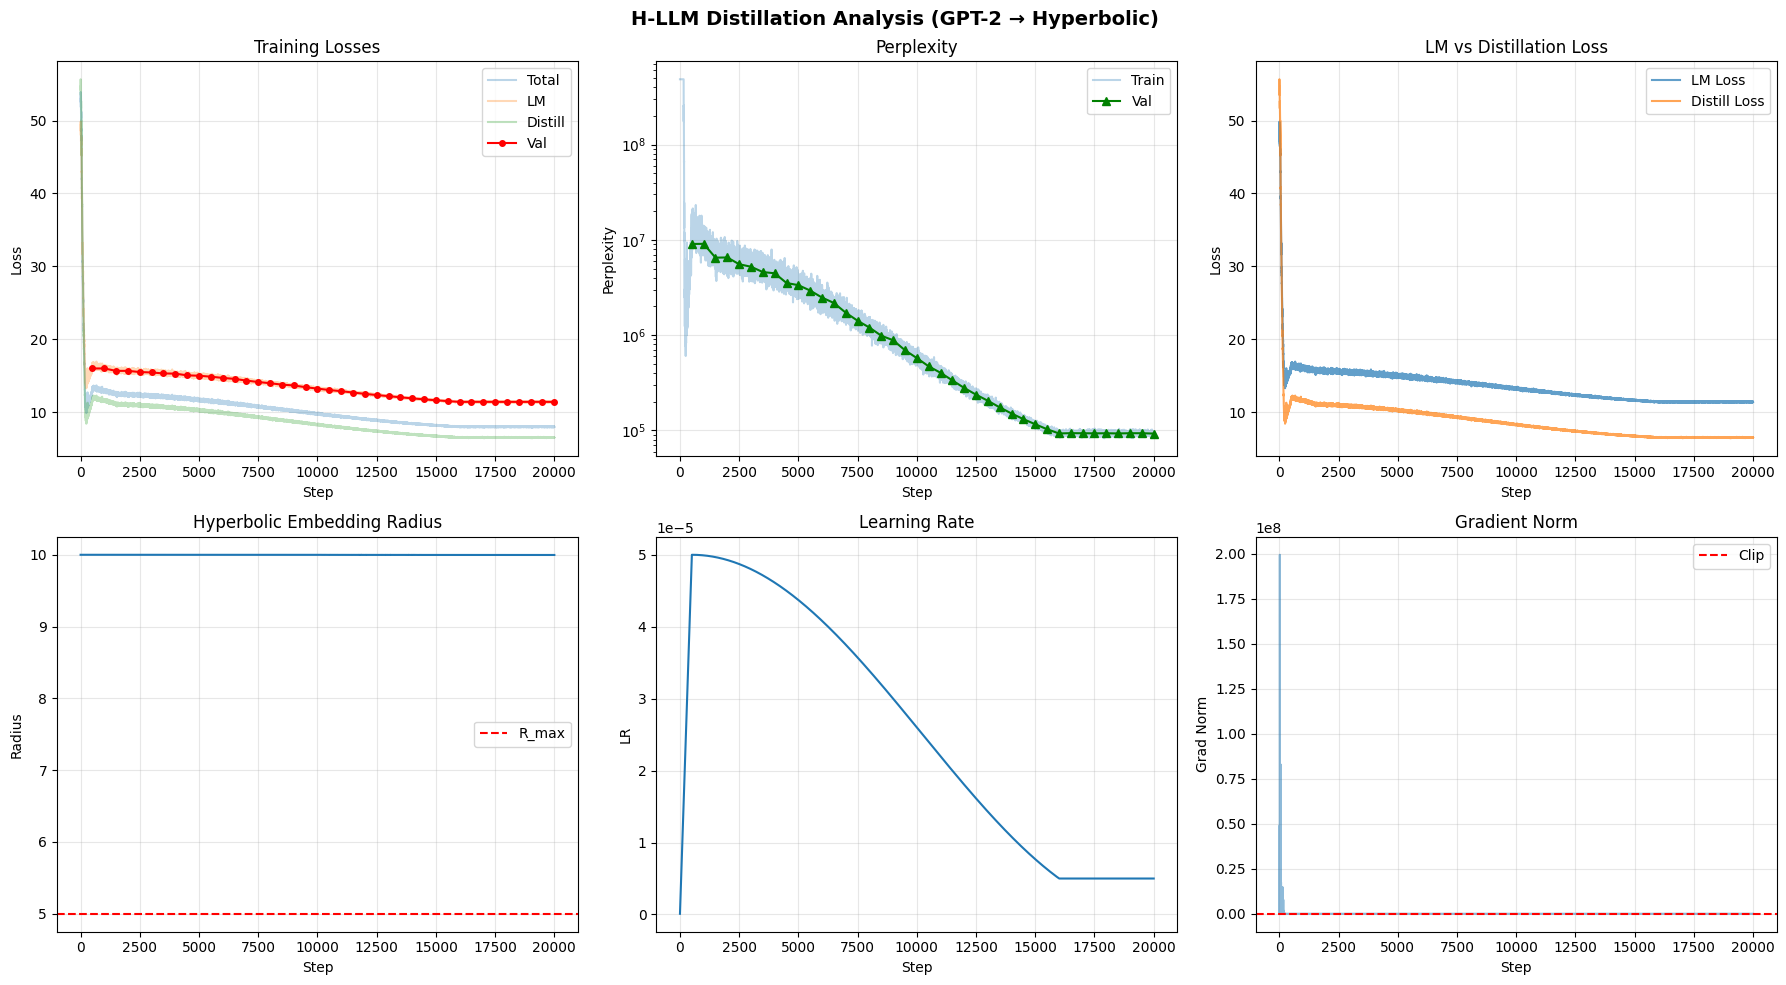

📊 Saved: /content/outputs/h_llm/distillation_analysis.png


In [ ]:
# @title 15. Distillation Analysis Plots
if distill_train_hist:
    plot_distillation_analysis(
        distill_train_hist,
        distill_val_hist,
        OUTPUT_DIR / "distillation_analysis.png"
    )

In [ ]:
# @title 16. Load Best Distilled Model
distill_best = CHECKPOINT_DIR / "distill_best.pt"
if distill_best.exists():
    ckpt = torch.load(distill_best, map_location=DEVICE)
    model.load_state_dict(ckpt["model"])
    print(f"✅ Best distilled model loaded from step {ckpt['step']}")
    print(f"   Val loss: {ckpt['best_val']:.4f}")
    print(f"   Val PPL: {math.exp(min(ckpt['best_val'], 20)):.1f}")
else:
    # Fallback to regular best
    best = CHECKPOINT_DIR / "best.pt"
    if best.exists():
        ckpt = torch.load(best, map_location=DEVICE)
        model.load_state_dict(ckpt["model"])
        print(f"✅ Best model loaded from step {ckpt['step']}")

model.eval()
print("\n🔮 Model ready for chat!")

✅ Best distilled model loaded from step 16000
   Val loss: 11.4390
   Val PPL: 92876.5

🔮 Model ready for chat!


In [ ]:
# @title 17. 🗣️ Chat Interativo com H-LLM
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output

# ============================================================================
# CHAT CLASS
# ============================================================================
class HyperbolicChat:
    def __init__(self, model, tokenizer, device):
        self.model = model
        self.tokenizer = tokenizer
        self.device = device
        self.conversation = []
        self.max_context = 512

    def add_message(self, role, content):
        self.conversation.append({
            'role': role,
            'content': content,
            'time': datetime.now().strftime('%H:%M:%S')
        })

    @torch.no_grad()
    def generate(self, prompt, max_tokens=100, temperature=0.8, top_k=50, top_p=0.95):
        self.model.eval()

        # Build context from conversation
        context = ""
        for msg in self.conversation:
            prefix = "User: " if msg['role'] == 'user' else "Assistant: "
            context += prefix + msg['content'] + "\n"
        context += "User: " + prompt + "\nAssistant:"

        # Tokenize
        input_ids = self.tokenizer.encode(context, return_tensors='pt').to(self.device)

        # Truncate if too long
        if input_ids.shape[1] > self.max_context:
            input_ids = input_ids[:, -self.max_context:]

        # Generate
        generated = []
        for _ in range(max_tokens):
            outputs = self.model(input_ids)
            logits = outputs['logits'][:, -1, :]

            # Temperature
            if temperature != 1.0:
                logits = logits / temperature

            # Top-k
            if top_k > 0:
                indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
                logits[indices_to_remove] = float('-inf')

            # Top-p
            if top_p < 1.0:
                sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)
                sorted_indices_to_remove = cumulative_probs > top_p
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
                sorted_indices_to_remove[..., 0] = 0
                indices_to_remove = sorted_indices_to_remove.scatter(1, sorted_indices, sorted_indices_to_remove)
                logits[indices_to_remove] = float('-inf')

            # Sample
            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)

            # Stop at EOS or newline (end of response)
            if next_token.item() == self.tokenizer.eos_token_id:
                break

            generated.append(next_token.item())
            input_ids = torch.cat([input_ids, next_token], dim=1)

            # Truncate
            if input_ids.shape[1] > self.max_context:
                input_ids = input_ids[:, -self.max_context:]

            # Stop at newline (simple response boundary)
            decoded = self.tokenizer.decode([next_token.item()])
            if '\n' in decoded and len(generated) > 10:
                break

        response = self.tokenizer.decode(generated, skip_special_tokens=True).strip()
        return response

    def chat(self, user_input, **kwargs):
        self.add_message('user', user_input)
        response = self.generate(user_input, **kwargs)
        self.add_message('assistant', response)
        return response

    def clear(self):
        self.conversation = []

    def get_html(self):
        html = '''
        <style>
            .chat-box { max-height: 400px; overflow-y: auto; padding: 10px;
                        border: 1px solid #ddd; border-radius: 10px; background: #f5f5f5; }
            .msg { margin: 8px 0; padding: 10px 15px; border-radius: 15px; max-width: 85%; }
            .user { background: #007bff; color: white; margin-left: auto; text-align: right; }
            .assistant { background: #28a745; color: white; }
            .role { font-size: 0.75em; font-weight: bold; margin-bottom: 3px; }
            .time { font-size: 0.65em; opacity: 0.7; margin-top: 3px; }
            .stats { font-size: 0.8em; color: #666; padding: 5px; margin-top: 10px;
                     background: white; border-radius: 5px; }
        </style>
        <div class="chat-box" id="chat-box">
        '''
        for msg in self.conversation:
            cls = msg['role']
            icon = '👤' if cls == 'user' else '🔮'
            html += f'''
            <div class="msg {cls}">
                <div class="role">{icon} {cls.title()}</div>
                <div>{msg['content']}</div>
                <div class="time">{msg['time']}</div>
            </div>
            '''
        html += f'''
        <div class="stats">💬 {len(self.conversation)} messages | 🔮 H-LLM Hyperbolic</div>
        </div>
        <script>document.getElementById('chat-box').scrollTop = document.getElementById('chat-box').scrollHeight;</script>
        '''
        return html

# ============================================================================
# INTERFACE
# ============================================================================
chat = HyperbolicChat(model, tokenizer, DEVICE)

# Output area
output = widgets.Output()

# Input
input_box = widgets.Textarea(
    placeholder='Digite sua mensagem...',
    layout=widgets.Layout(width='100%', height='60px')
)

# Buttons
send_btn = widgets.Button(description='📤 Enviar', button_style='primary')
clear_btn = widgets.Button(description='🗑️ Limpar', button_style='warning')
save_btn = widgets.Button(description='💾 Salvar', button_style='info')

# Parameters
temp_slider = widgets.FloatSlider(value=0.8, min=0.1, max=2.0, step=0.1, description='Temperatura:')
tokens_slider = widgets.IntSlider(value=100, min=20, max=300, step=10, description='Max Tokens:')
topk_slider = widgets.IntSlider(value=50, min=0, max=100, step=10, description='Top-K:')
topp_slider = widgets.FloatSlider(value=0.95, min=0.5, max=1.0, step=0.05, description='Top-P:')

def update():
    with output:
        clear_output(wait=True)
        display(HTML(chat.get_html()))

def on_send(b):
    text = input_box.value.strip()
    if not text:
        return
    input_box.value = ''

    with output:
        clear_output(wait=True)
        display(HTML(chat.get_html() + '<p style="color:#888">🔄 Generating...</p>'))

    chat.chat(
        text,
        max_tokens=tokens_slider.value,
        temperature=temp_slider.value,
        top_k=topk_slider.value,
        top_p=topp_slider.value
    )
    update()

def on_clear(b):
    chat.clear()
    update()

def on_save(b):
    path = OUTPUT_DIR / f'chat_{datetime.now().strftime("%Y%m%d_%H%M%S")}.json'
    with open(path, 'w') as f:
        json.dump(chat.conversation, f, indent=2)
    print(f"💾 Saved: {path}")

send_btn.on_click(on_send)
clear_btn.on_click(on_clear)
save_btn.on_click(on_save)

# Layout
header = widgets.HTML('''
<h2>🔮 Chat com H-LLM (Hyperbolic Language Model)</h2>
<p style="color:#666">Modelo treinado com geometria hiperbólica e tokenizer GPT-2</p>
''')

params_box = widgets.VBox([
    widgets.HTML('<b>⚙️ Parâmetros de Geração:</b>'),
    widgets.HBox([temp_slider, tokens_slider]),
    widgets.HBox([topk_slider, topp_slider]),
])

buttons_box = widgets.HBox([send_btn, clear_btn, save_btn])

# Display
display(header)
display(params_box)
display(output)
display(input_box)
display(buttons_box)

update()

print('''
╔════════════════════════════════════════════════════════════════╗
║  🔮 H-LLM Chat Interativo                                      ║
╠════════════════════════════════════════════════════════════════╣
║  • Digite sua mensagem na caixa de texto                       ║
║  • Ajuste os parâmetros com os sliders                         ║
║  • Clique "Enviar" ou pressione Shift+Enter                    ║
║  • O histórico completo é mantido como contexto                ║
╚════════════════════════════════════════════════════════════════╝
''')

HTML(value='\n<h2>🔮 Chat com H-LLM (Hyperbolic Language Model)</h2>\n<p style="color:#666">Modelo treinado com…

Output()

Textarea(value='', layout=Layout(height='60px', width='100%'), placeholder='Digite sua mensagem...')


╔════════════════════════════════════════════════════════════════╗
║  🔮 H-LLM Chat Interativo                                      ║
╠════════════════════════════════════════════════════════════════╣
║  • Digite sua mensagem na caixa de texto                       ║
║  • Ajuste os parâmetros com os sliders                         ║
║  • Clique "Enviar" ou pressione Shift+Enter                    ║
║  • O histórico completo é mantido como contexto                ║
╚════════════════════════════════════════════════════════════════╝



In [ ]:
# @title 18. Save to Google Drive
SAVE_TO_DRIVE = True  # @param {type:"boolean"}

if SAVE_TO_DRIVE:
    from google.colab import drive
    import shutil

    drive.mount('/content/drive')

    dp = Path('/content/drive/MyDrive/H-LLM_Checkpoints')
    dp.mkdir(parents=True, exist_ok=True)
    ts = datetime.now().strftime('%Y%m%d_%H%M%S')

    for f in ['best.pt', 'latest.pt']:
        src = CHECKPOINT_DIR / f
        if src.exists():
            shutil.copy(src, dp / f'{f.replace(".pt", "")}_{ts}.pt')
            print(f"✅ Saved {f}")

    plot = OUTPUT_DIR / 'training_analysis.png'
    if plot.exists():
        shutil.copy(plot, dp / f'analysis_{ts}.png')

    print(f"\n📁 Files saved to: {dp}")

Mounted at /content/drive

📁 Files saved to: /content/drive/MyDrive/H-LLM_Checkpoints


## 📋 Summary

### ✅ Features:
- **GPT-2 Tokenizer** (50257 tokens reais)
- **WikiText-2** dataset real
- **🎓 GPT-2 Distillation** - transferência de conhecimento
- **Checkpoints** automáticos
- **Early Stopping** inteligente
- **Chat Interativo** com parâmetros ajustáveis

### 🔧 Fluxo:
1. Células 1-10: Setup + Treino básico (opcional)
2. Células 11-16: **Distillation GPT-2 → H-LLM**
3. Célula 17: Chat interativo

### 💬 Chat Parâmetros:
- **Temperatura**: Criatividade (0.1=conservador, 2.0=criativo)
- **Max Tokens**: Tamanho máximo da resposta
- **Top-K**: Filtro de tokens mais prováveis
- **Top-P**: Nucleus sampling